# Autism diagnosis with Neural Networks

On this project, we try to diagnose autism patients from from MRI's raw input data.

To do this job, we get data from Abide and Abide II:

* [ABIDE Data](http://fcon_1000.projects.nitrc.org/indi/abide/ABIDE_LEGEND_V1.02.pdf)
* [ABIDE II Phenotypic Data](http://fcon_1000.projects.nitrc.org/indi/abide/ABIDEII_Data_Legend.pdf)

*This is only a quick view of how Neural Network can help on these kind of problems, so we decided to take a small images (6mm) just to simplify the network, and not to spend long time on the training process the net.

All software and data is free, so every one can use it!

## Let's do it!

We will do it in Python3, so first we will need next librarys:

* [Nibabel](http://nipy.org/nibabel/manual.html#manua l): Read MRI images (*.nii.gz)
* [Numpy](http://www.numpy.org/): Work with images data
* [Keras](https://keras.io/): For Neural Networks (NN) implementation. We will use [TensorFlow](https://www.tensorflow.org/) as backend.
* [MatPlotLib](http://matplotlib.org/): Plot different data results.

In [1]:
%matplotlib inline
import os
import csv
import numpy as np
import nibabel as nib

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D

from keras.models import load_model

from keras.optimizers import SGD

import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


### Explaining oue data structure

Next to this notebook we have a folder (named ABIDE) with all ABIDE data aviable, with all this data:

* Autism&#x268A;diagnosis.ipynb
* ABIDE/
    * Phenotypic&#x268A;V1&#x268A;0&#x268A;b.csv
    * ABIDEII&#x268A;CompositeP&#x268A;henotypic.csv
    * weighted&#x268A;degree/
        * (SITE&#x268A;ID)&#x268A;(SUB&#x268A;ID).nii.gz
    * weighted&#x268A;degree&#x268A;II/
        * (SITE&#x268A;ID)&#x268A;(SUB&#x268A;ID).nii.gz
* 6mm/
    * avg152T1&#x268A;(mask&#x268A;type)&#x268A;bin.nii.gz
    
#### Reading FMR images names for each location

We will read both images directories and save each image name in a `<names>` variable.

In [2]:
directory = "./ABIDE/weighted_degree"
names = []
for filename in os.listdir(directory):
    if filename.endswith(".nii.gz"): 
        names.append(os.path.join(directory, filename))
        
directory = "./ABIDE/weighted_degree_II"
for filename in os.listdir(directory):
    if filename.endswith(".nii.gz"): 
        names.append(os.path.join(directory, filename))

print("Number of images found:")
print(len(names))

Number of images found:
2152


#### Read csv files

After reading existing images, we need to read .csv files to know if a patient has autism or not:

* ABIDE/
    * Phenotypic&#x268A;V1&#x268A;0&#x268A;b.csv [Explanation](http://fcon_1000.projects.nitrc.org/indi/abide/ABIDE_LEGEND_V1.02.pdf)
    * ABIDEII&#x268A;CompositeP&#x268A;henotypic.csv [Explanation](http://fcon_1000.projects.nitrc.org/indi/abide/ABIDEII_Data_Legend.pdf)

In [3]:
y_data = np.full((len(names),1), 10, dtype = np.dtype('int16'))
with open('./ABIDE/Phenotypic_V1_0b.csv') as csvfile:
    d = csv.reader(csvfile)#, delimiter=' ', quotechar='|')
    for row in d:
        name = [str(x) for x in names if row[1] in str(x)]
        if len(name)>0:
            name = name[0]
        else:
            continue
        try:
            i = names.index(name)
            y_data[i] = row[3]
        except Exception as e:
            pass

with open('./ABIDE/ABIDEII_Composite_Phenotypic.csv','r', encoding='latin-1') as csvfile:
    d = csv.reader(csvfile)#, delimiter=' ', quotechar='|')
    for row in d:
        name = [str(x) for x in names if row[1] in str(x)]
        if len(name)>0:
            name = name[0]
        else:
            continue
        try:
            i = names.index(name)
            y_data[i] = row[3]
        except Exception as e:
            pass

print("Shape of output:")    
print(y_data.shape)

Shape of output:
(2152, 1)


We can not match all brains with their raw data and their lesion, so we have to select thouse that we match

In [4]:
# Convert names Array into Numpy array
names = np.asarray(names)

# Select thouse values that match img_name and autims value
to_select = y_data != 10
to_select = to_select.reshape(to_select.shape[0])
print("To select:",np.sum(to_select))

names = names[to_select]
y_data = y_data[to_select,:]
y_data = y_data > 0

#create autism other values
y_data = np.concatenate((y_data, 1-y_data), axis=1)

print("New shapes:")
print("x:",names.shape)
print("y:",y_data.shape)
print("brains with no lesion:", np.sum(y_data[:,0] == 0))

To select: 2114
New shapes:
x: (2114,)
y: (2114, 2)
brains with no lesion: 590


#### Filtering data

Since data has been taken from different sites and machines, it could be difficult to find different from each images. So we dicede to have the opportunity of select one of the different locations:

In [5]:
locations = []
number = []
for n in names:
    a = n.split("/")[-1].split("_")[0].split("-")[-1]
    if a not in locations:
        locations.append(a)
        number.append(1)
    else:
        i = locations.index(a)
        number[i] += 1
print("Different locations:")
for i in range(len(locations)):
        print("  ",i,locations[i], "\t", number[i], "examples")


Different locations:
   0 Caltech 	 38 examples
   1 CMU 	 27 examples
   2 KKI 	 266 examples
   3 Leuven 	 64 examples
   4 MaxMun 	 57 examples
   5 NYU 	 289 examples
   6 OHSU 	 121 examples
   7 Olin 	 36 examples
   8 Pitt 	 57 examples
   9 SBL 	 30 examples
   10 SDSU 	 94 examples
   11 Trinity 	 49 examples
   12 UCLA 	 141 examples
   13 UM 	 145 examples
   14 USM 	 134 examples
   15 Yale 	 56 examples
   16 BNI 	 58 examples
   17 EMC 	 54 examples
   18 ETH 	 37 examples
   19 GU 	 106 examples
   20 IP 	 55 examples
   21 IU 	 39 examples
   22 KUL 	 28 examples
   23 ONRC 	 59 examples
   24 TCD 	 42 examples
   25 UCD 	 32 examples


Now select the index of the examples brains: (-1 for all)

In [6]:
site_index = -1

if site_index != -1:
    select_site = np.zeros(y_data.shape[0])
    selected_site_name = locations[site_index]
    i  = 0 
    for n in names:
        a = n.split("/")[-1].split("_")[0].split("-")[-1]
        if a == selected_site_name:
            select_site[i] = 1
        i += 1
    print("Selected:")
    print("\tName:", selected_site_name)  
    print("\tNumber:", int(np.sum(select_site))) 

    select_site = select_site > 0
    names = names[select_site]
    y_data = y_data[select_site,:]
print("Names:", names.shape)
print("y_data:", y_data.shape)

Names: (2114,)
y_data: (2114, 2)


#### Mask

Now we have to select which mask use to reduce raw input:

* white: brain mask
* blue: gray mask
* yellow: white mask
* green: csf mask

<div>
<span style="display:inline-block; position:relative"></span>
<img src="files/6mm/top.gif" width="15%" style="display:inline-block; position:relative"/>
<img src="files/6mm/r.gif" width="15%" style="display:inline-block; position:relative"/>
<img src="files/6mm/left.gif" width="15%" style="display:inline-block; position:relative"/>
</div>



In [7]:
mask_types = ['brain','csf', 'gray', 'white']
mask_index = 0
mask = nib.load("./6mm/avg152T1_"+mask_types[mask_index]+"_bin.nii.gz").get_data()
num = mask.shape[0]*mask.shape[1]*mask.shape[2]
mask = mask.reshape(num) > 0
print(mask.shape)
print(np.sum(mask))

(32400,)
10643


### Read raw imput

Read only needed raw imput

In [8]:
x_data = []
for image in names:
    im = nib.load(image).get_data()
    im = im.reshape(num)
    im = im[mask]
    x_data.append(im)

x_data = np.asarray(x_data)

print("Shape of input:")
print(x_data.shape)

Shape of input:
(2114, 10643)


### Split to train/test

In [9]:
#shuffle the data
r = np.random.permutation(x_data.shape[0])
x_data = x_data[r,:]
y_data = y_data[r,:]

train = 0.70
bb = int(y_data.shape[0]*train)

x_data_tr = x_data[:bb,:]
y_data_tr = y_data[:bb,:]

x_data_ts = x_data[bb:,:]
y_data_ts = y_data[bb:,:]

print("New train and test data:")
print("Train:", x_data_tr.shape, y_data_tr.shape)
print("Test:", x_data_ts.shape, y_data_ts.shape)

New train and test data:
Train: (1479, 10643) (1479, 2)
Test: (635, 10643) (635, 2)


### Building the net

In [10]:
print(np.sum(y_data_tr[:,1]))
print(np.sum(y_data_tr[:,0]))

409
1070


In [30]:
model = Sequential()
input_shape=x_data.shape[1:]

# number of convolutional filters to use
nb_filters = 8
# size of pooling area for max pooling
pool_size = (2, 2, 2)
# convolution kernel size
kernel_size = (3, 3, 3)

nb_classes = 2
print("Input shape to the network:", input_shape)

model.add(Dense(4096,activation='tanh',input_shape=input_shape))
print("Output shape after:", model.output_shape)

model.add(Dense(512,activation='tanh'))
print("Output shape after:", model.output_shape)

model.add(Dense(128,activation='tanh'))
print("Output shape after:", model.output_shape)

model.add(Dense(nb_classes,activation='softmax'))
print("Output shape after softmax (2 classes):", model.output_shape)

Input shape to the network: (10643,)
Output shape after: (None, 4096)
Output shape after: (None, 512)
Output shape after: (None, 128)
Output shape after softmax (2 classes): (None, 2)


### Train the net

In [12]:
#balance the data
def balance(balance_rate, x_data_tr, y_data_tr):

    r = np.random.permutation(x_data_tr.shape[0])
    x_data_tr = x_data_tr[r,:]
    y_data_tr = y_data_tr[r,:]

    a = np.where(y_data_tr[:,0] == 1)[0]
    b = np.where(y_data_tr[:,0] == 0)[0]
    print("Unbalance:", a.shape, b.shape)
    if a.shape[0] > b.shape[0]:
        num = int(b.shape[0]*balance_rate)
    else:
        num = int(a.shape[0]*balance_rate)
    a = a[:num]
    b = b[:num]
    print("Balance:", a.shape, b.shape)
    a = np.append(a,b)
    print(a.shape)
    x_data_tr_t = x_data_tr[a]
    y_data_tr_t = y_data_tr[a]
    print(x_data_tr_t.shape)
    return((x_data_tr_t, y_data_tr_t))

In [31]:
batch_size = 128
nb_epoch = 100

init_bal = 1
final_bal = 1.5
dec_bal = (final_bal/init_bal)**(1/nb_epoch)

init_ler = 0.05
final_ler = 0.005
dec = (final_ler/init_ler)**(1/nb_epoch)

tr_h = {}
tr_h["bal"] = []
tr_h["ler"] = []
tr_h["loss"] = []
tr_h["acc"] = []

model_name = "model_data_"+str(site_index)+\
           "_mask_"+mask_types[mask_index]+\
           "_train_"+str(train)+\
           "_epoch_"+str(nb_epoch)+\
           "_bal_"+str(init_bal)+"_"+str(final_bal)+\
           "_ler_"+str(init_ler)+"_"+str(final_ler)+\
           ".mdl"

sgd = SGD(lr=init_ler,decay=dec,momentum=0.9,nesterov = False)
model.compile(loss='cosine_proximity',#['binary_crossentropy',cosine_proximity','categorical_crossentropy']
                   optimizer=sgd,
                   metrics=['accuracy'])

for ep in range(nb_epoch):
    print("Epoca:", ep+1, "/",nb_epoch)
    t = balance(init_bal, x_data_tr, y_data_tr)
    tr_h["bal"].append(init_bal)
    tr_h["ler"].append(init_ler)
    z = model.fit(t[0],t[1], batch_size=batch_size, nb_epoch=1,verbose=2)
    tr_h["loss"].append(z.history["loss"][0])
    tr_h["acc"].append(z.history["acc"][0])
    init_bal *= dec_bal
    init_ler *= dec
    

Epoca: 1 / 100
Unbalance: (1070,) (409,)
Balance: (409,) (409,)
(818,)
(818, 10643)
Epoch 1/1
9s - loss: -3.0606e-01 - acc: 0.4768
Epoca: 2 / 100
Unbalance: (1070,) (409,)
Balance: (410,) (409,)
(819,)
(819, 10643)
Epoch 1/1
10s - loss: -3.5452e-01 - acc: 0.5421
Epoca: 3 / 100
Unbalance: (1070,) (409,)
Balance: (412,) (409,)
(821,)
(821, 10643)
Epoch 1/1
9s - loss: -3.5340e-01 - acc: 0.5079
Epoca: 4 / 100
Unbalance: (1070,) (409,)
Balance: (414,) (409,)
(823,)
(823, 10643)
Epoch 1/1
8s - loss: -3.5512e-01 - acc: 0.5310
Epoca: 5 / 100
Unbalance: (1070,) (409,)
Balance: (415,) (409,)
(824,)
(824, 10643)
Epoch 1/1
11s - loss: -3.5271e-01 - acc: 0.5061
Epoca: 6 / 100
Unbalance: (1070,) (409,)
Balance: (417,) (409,)
(826,)
(826, 10643)
Epoch 1/1
11s - loss: -3.4893e-01 - acc: 0.5036
Epoca: 7 / 100
Unbalance: (1070,) (409,)
Balance: (419,) (409,)
(828,)
(828, 10643)
Epoch 1/1
11s - loss: -3.5569e-01 - acc: 0.5423
Epoca: 8 / 100
Unbalance: (1070,) (409,)
Balance: (420,) (409,)
(829,)
(829, 10

### Saving the model

In [17]:
model.save(model_name)

### Ploting trainning process

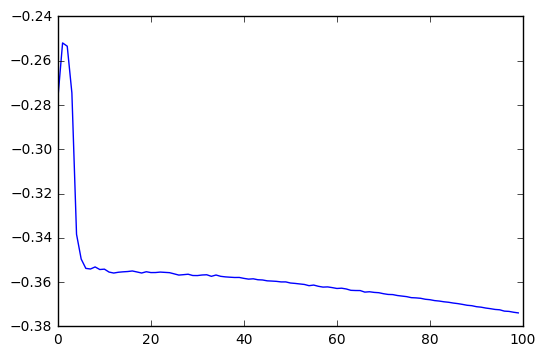

In [26]:
fig, ax = plt.subplots(1)
ax.plot(tr_h["loss"])

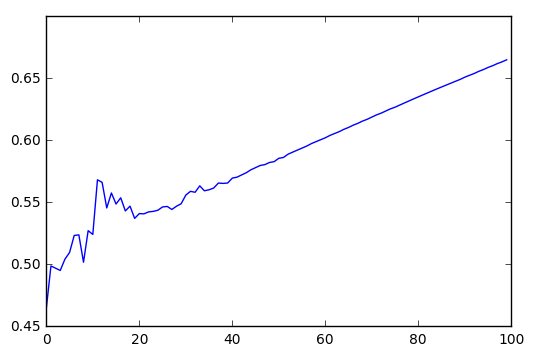

In [27]:
fig, ax = plt.subplots(1)
ax.plot(tr_h["acc"])

### Load saved model

In [17]:
model = load_model("model_data_-1_mask_brain_train_0.7_epoch_100_bal_1_3_ler_0.05_0.005.mdl")

### Testing model

In [28]:
predicted = model.predict(x_data_ts)

#creating matrix
# [TP, FN]
# [FP, TN]
th = 0.5

m = [[0,0],[0,0]]
for i in range(predicted.shape[0]):
    a = predicted[i,0] > th
    b = y_data_ts[i,0] > th
    if a:
        if b:
            m[0][0] += 1
        else:
            m[1][0] += 1
    else:
        if b:
            m[0][1] += 1
        else:
            m[1][1] += 1
            
print("Matrix")
print("Pred  \t   T   F")
print("Real T\t",m[0])
print("Real F\t",m[1])
print("\nAccuracy:", (m[0][0]+m[1][1])/(m[0][0]+m[0][1]+m[1][0]+m[1][1]))

Matrix
Pred  	   T   F
Real T	 [454, 0]
Real F	 [181, 0]

Accuracy: 0.7149606299212599


In [29]:
# print(np.sum(predicted[:,1] == 0.5))
print(predicted[1:4,:])
np.sum(y_data[:,1])/np.sum(y_data)
tr_h["acc"][-1]

[[ 0.65933722  0.34066269]
 [ 0.66013479  0.33986521]
 [ 0.65841192  0.34158808]]


0.66502866595617383